# IMPORT LIBRARIES

In [1]:
%tensorflow_version 2.x

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import os
import pickle
import h5py
from google.colab import drive # Necessary to access data stored in google drive 

# DEFINITION OF DIRECTORIES

The data will be stored in Google Drive, so that we can access it easily from Google Colab. Therefore, we must mount Google Drive and define the directories where the images are stored within Google Drive.

We might load the images directly from the folders stored in Google Drive. However, Google Colab is very slow at doing this, thus creating a bottleneck. Therefore, we will load the images once directly into numpy tensors from an hdf5 file.

In [4]:
drive.mount('/content/gdrive')

# %% 0 - Definition of directories

base_dir = '/content/gdrive/MyDrive/'

with h5py.File(os.path.join(base_dir, "cats_and_dogs_small.hdf5"), "r") as file:

  # print(file.items())

  train_group = file.get('training')
  # print(train_group.items())
  train_images_aux = train_group.get('images')
  train_images = train_images_aux[()]
  train_images = train_images.astype(np.float64)
  train_labels_aux = train_group.get('labels')
  train_labels = train_labels_aux[()]

  validation_group = file.get('validation')
  # print(validation_group.items())
  validation_images_aux = validation_group.get('images')
  validation_images = validation_images_aux[()]
  validation_images = validation_images.astype(np.float64)
  validation_labels_aux = validation_group.get('labels')
  validation_labels = validation_labels_aux[()]

  test_group = file.get('test')
  # print(test_group.items())
  test_images_aux = test_group.get('images')
  test_images = test_images_aux[()]
  test_images = test_images.astype(np.float64)
  test_labels_aux = test_group.get('labels')
  test_labels = test_labels_aux[()]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. TRAINING FROM SCRATCH

### 1.1. - Building the Network

The input images have a size 150 × 150 (a somewhat arbitrary choice), you end
up with feature maps of size 7 × 7 just before the Flatten layer.

NOTE: The depth of the feature maps progressively increases in the network
(from 32 to 128), whereas the size of the feature maps decreases (from
148 × 148 to 7 × 7). This is a pattern you’ll see in almost all convnets.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Display the architecture of the CNN

In [6]:
print('\n\n**********************************************************')
print('**** ARCHITECTURE OF THE CONVOLUTIONAL NEURAL NETWORK ****')
print('**********************************************************\n')
model.summary()



**********************************************************
**** ARCHITECTURE OF THE CONVOLUTIONAL NEURAL NETWORK ****
**********************************************************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_

Compile the model

In [7]:
model.compile(optimizer='Adam', metrics=['accuracy'], loss='binary_crossentropy')

### 1.2. - Preprocessing the data

As you know by now, data should be formatted into appropriately
preprocessed floating- point tensors before being fed into the network.
Currently, the data sits on tensors loaded from a hdf5 file, so the steps for getting it into the network are roughly as follows:
         

1.   Use the images from the loaded tensors.
2.   Convert these into floating-point tensors.
3.   Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).


In [8]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow(x=np.array(train_images), y=train_labels, batch_size=20)

validation_gen = train_datagen.flow(x=np.array(validation_images), batch_size=20)

Showing the first image from the train generator

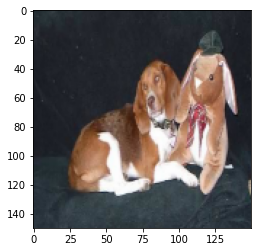

In [9]:
x_batch, ybatch = next(train_gen)

img = x_batch[0]
plt.figure()
plt.imshow(img)
plt.show()

### 1.3. - Fitting the model using a batch generator

In [15]:
fname_model_from_scratch = os.path.join(base_dir, 'models',
                                        'a_cats_vs_dogs_small_from_scratch.h5')

history = model.fit(train_gen, steps_per_epoch=10, epochs=30, verbose=1, validation_data=validation_gen, validation_steps=10)
  
# Saving the model (Good practice to use it in the future)
print('\n\nSaving model to file.')
model.save(fname_model_from_scratch)


Epoch 1/30


NotFoundError: ignored

Displaying curves of loss and accuracy during training

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training ac')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored

### 1.4. - Prediction of the instances in the test set

In [19]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow(x = np.array(test_images), batch_size=1)

nb_test_samples = len(test_labels)

predicted_probabilities = model.predict()

predicted_classes_bin = predicted_probabilities >= 0.5
predicted_classes_bin = predicted_classes_bin.astype('int32').reshape((1000,))

TypeError: ignored

Print the performance metrics (i.e. accuracy and Confusion Matrix)

In [20]:
accuracy = accuracy_score(test_labels, predicted_classes_bin)
print()
print('Accuracy (Convolutional Neural Network)= {}'.format(accuracy))
cm = confusion_matrix(predicted_classes_bin, test_labels)
print('Confusion Matrix with Convolutional Neural Network: ')
print(cm)
print('***********************************************')
print('***********************************************')
print()

NameError: ignored

# 2. USING DATA AUGMENTATION

### 2.1. - Setting up the image generator which performs data augmentation

Setting up a data augmentation configuration via ImageDataGenerator

In [21]:
train_datagen = ImageDataGenerator(
  rotation_range = 40,
  horizontal_flip=True,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  rescale=1./ 255,
  zoom_range = 0.2,
  vertical_flip = True
)

Displaying some randomly augmented images

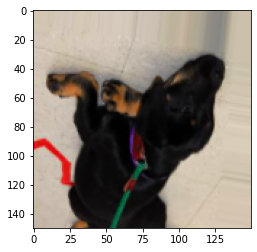

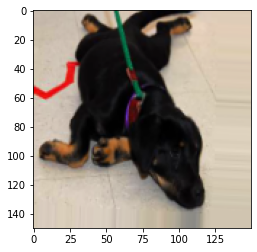

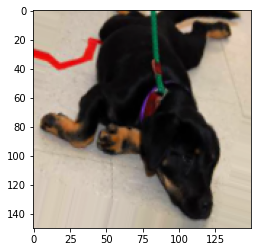

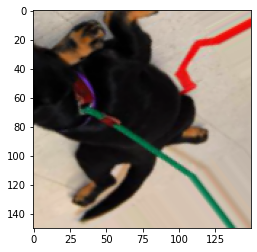

In [22]:
img = train_images[23,:,:,:]

img2 = image.img_to_array(img)
img2 = img2.reshape((1,) + img2.shape)

i = 0
for batch in train_datagen.flow(img2, batch_size=1):
  plt.figure(1)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break

  plt.show()

### 2.2. - Defining network architecture adding Dropout

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images — you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a **Dropout** layer to your model, right before the densely connected classifier.

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Display the architecture of the CNN

In [24]:
print('\n\n**********************************************************')
print('**** ARCHITECTURE OF THE CONVOLUTIONAL NEURAL NETWORK ****')
print('**********************************************************\n')
model.summary()



**********************************************************
**** ARCHITECTURE OF THE CONVOLUTIONAL NEURAL NETWORK ****
**********************************************************

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2

Compile the model

In [25]:
model.compile(optimizer='Adam', metrics=['accuracy'], loss='binary_crossentropy')

### 2.3. - Training the network using the data-augmentation generator

In [26]:
fname_model_data_augment = os.path.join(base_dir, 'models',
                                        'b_cats_vs_dogs_small_data_augment.h5')

validation_datagen = ImageDataGenerator(rescale=1/255)
  
train_generator = train_datagen.flow(x = np.array(train_images), y = train_labels, batch_size = 20)

validation_generator = train_datagen.flow(x=np.array(validation_images), batch_size=20)

history = model.fit(train_generator, steps_per_epoch=100, epochs=100, verbose=1, validation_data=validation_generator, validation_steps=10)
  
# Saving the model
print('\n\nSaving model to file.')
model.save(fname_model_data_augment)

Epoch 1/100


NotFoundError: ignored

Displaying curves of loss and accuracy during training

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training ac')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored

### 2.4. - Prediction of the instances in the test set

In [28]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow(x=np.array(test_images), batch_size = 1)

nb_test_samples = len(test_labels)

predicted_classes = model.predict(test_generator)

predicted_classes_bin = predicted_classes >= 0.5
predicted_classes_bin = predicted_classes_bin.astype('int32').reshape((1000,))

NotFoundError: ignored

Print the performance metrics (i.e. accuracy and Confusion Matrix)

In [29]:
accuracy = accuracy_score(test_labels, predicted_classes_bin)
print()
print('Accuracy (Convolutional Neural Network)= {}'.format(accuracy))
cm = confusion_matrix(predicted_classes_bin, test_labels)
print('Confusion Matrix with Convolutional Neural Network: ')
print(cm)
print('***********************************************')
print('***********************************************')
print()

NameError: ignored

# 3. USING A PRE-TRAINED MODEL FOR FEATURE EXTRACTION

Defining function for extracting features using a given convolutional base

In [30]:
def extract_features(x_images, y_labels, sample_count, datagen, batch_size, conv_base):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,))
  
  generator = datagen.flow(
      x=x_images,
      y=y_labels,
      batch_size=batch_size)

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch, verbose=1)
    features[i * batch_size:(i+1) * batch_size] = features_batch
    labels[i * batch_size:(i+1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  
  return features, labels

### 3.1. - Instantiating the convolutional base

We will use a pretrained VGG16 Network

In [31]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

### 3.2. - Fast Feature Extraction without data augmentation

Defining names for pickle files to save features into (or load them from)

In [32]:
fname_feats_train = os.path.join(base_dir, 'models',
                                 'c_cats_vs_dogs_small_train_feats.pkl')
fname_feats_valid = os.path.join(base_dir, 'models',
                                 'c_cats_vs_dogs_small_valid_feats.pkl')
fname_feats_test = os.path.join(base_dir, 'models',
                                'c_cats_vs_dogs_small_test_feats.pkl')
fname_labels_train = os.path.join(base_dir, 'models',
                                  'c_cats_vs_dogs_small_train_labels.pkl')
fname_labels_valid = os.path.join(base_dir, 'models',
                                  'c_cats_vs_dogs_small_valid_labels.pkl')
fname_labels_test = os.path.join(base_dir, 'models',
                                 'c_cats_vs_dogs_small_test_labels.pkl')

Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier similar to those you saw in the previous lab. This solution is fast and cheap to run, because it only requires running the
convolutional base once for every input image, and the convolutional base is by
far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

In [33]:
datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

num_samples_train = train_images.shape[0]
num_samples_valid = validation_images.shape[0]
num_samples_test = test_images.shape[0]

Extract features from training images

In [34]:
if not os.path.exists(fname_feats_train):
  train_features, train_labels = extract_features(train_images, train_labels, len(train_images), datagen, batch_size, conv_base)
  train_features = np.reshape(
      train_features,
      (train_features.shape[0], np.prod(train_features.shape[1:4])))

1/1 [==============================] - 0s 20ms/step


Extract features from validation images

In [35]:
if not os.path.exists(fname_feats_valid):

  validation_feats, validation_labels = extract_features(validation_images, validation_labels, len(validation_images), datagen, batch_size, conv_base)
  validation_feats = np.reshape(
      validation_feats,
      (validation_feats.shape[0], np.prod(validation_feats.shape[1:4])))

1/1 [==============================] - 0s 38ms/step


Extract features from test images

In [36]:
if not os.path.exists(fname_feats_test):

  test_features, test_labels = extract_features(test_images, test_labels, len(test_images), datagen, batch_size, conv_base)
  test_features = np.reshape(
      test_features,
      (test_features.shape[0], np.prod(test_features.shape[1:4])))

1/1 [==============================] - 0s 23ms/step


Saving features to pickle files

In [37]:
if not os.path.exists(fname_feats_train):
  output_train = open(fname_feats_train, 'wb')
  output_valid = open(fname_feats_valid, 'wb')
  output_test = open(fname_feats_test, 'wb')
  output_train_labels = open(fname_labels_train, 'wb')
  output_valid_labels = open(fname_labels_valid, 'wb')
  output_test_labels = open(fname_labels_test, 'wb')
  pickle.dump(train_features, output_train)
  pickle.dump(validation_feats, output_valid)
  pickle.dump(test_features, output_test)
  pickle.dump(train_labels, output_train_labels)
  pickle.dump(validation_labels, output_valid_labels)
  pickle.dump(test_labels, output_test_labels)
  output_train.close()
  output_valid.close()
  output_test.close()
  output_train_labels.close()
  output_valid_labels.close()
  output_test_labels.close()

else:
  input_train = open(fname_feats_train, 'rb')
  input_valid = open(fname_feats_valid, 'rb')
  input_test = open(fname_feats_test, 'rb')
  input_train_labels = open(fname_labels_train, 'rb')
  input_valid_labels = open(fname_labels_valid, 'rb')
  input_test_labels = open(fname_labels_test, 'rb')
  train_features = pickle.load(input_train)
  validation_feats = pickle.load(input_valid)
  test_features = pickle.load(input_test)
  train_labels = pickle.load(input_train_labels)
  validation_labels = pickle.load(input_valid_labels)
  test_labels = pickle.load(input_test_labels)
  input_train.close()
  input_valid.close()
  input_test.close()
  input_train_labels.close()
  input_valid_labels.close()
  input_test_labels.close()

FileNotFoundError: ignored

### 3.3. - Define and train a densly connected neural network

In [38]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='RMSProp', metrics=['accuracy'], loss='binary_crossentropy')

history = model.fit(train_features, steps_per_epoch=100, epochs = 30, verbose = 1, validation_data = validation_feats, validation_steps = 100)
  

ValueError: ignored

Displaying curves of loss and accuracy during training

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training ac')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored

### 3.4. - Prediction of the instances in the test set

In [40]:
predicted_classes = model.predict(test_features)

predicted_classes_bin = predicted_classes >= 0.5
predicted_classes_bin = predicted_classes_bin.astype('int32').reshape((1000,))

Print the performance metrics (i.e. accuracy and Confusion Matrix)

In [41]:
accuracy = accuracy_score(test_labels, predicted_classes_bin)
print()
print('Accuracy (Convolutional Neural Network)= {}'.format(accuracy))
cm = confusion_matrix(predicted_classes_bin, test_labels)
print('Confusion Matrix with Convolutional Neural Network: ')
print(cm)
print('***********************************************')
print('***********************************************')
print()


Accuracy (Convolutional Neural Network)= 0.5
Confusion Matrix with Convolutional Neural Network: 
[[  0   0]
 [500 500]]
***********************************************
***********************************************

